In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano

np.random.seed(42)
pm.set_tt_rng(42)



In [23]:
w = pm.floatX([0.2, 0.8])
mu = pm.floatX([-0.3, 0.5])
sd = pm.floatX([0.1, 0.1])

with pm.Model() as model:
    x = pm.NormalMixture("x", w=w, mu=mu, sigma=sd, dtype=theano.config.floatX)
    x2 = x ** 2
    sin_x = pm.math.sin(x)


In [25]:
with model:
    pm.Deterministic("x2", x2)
    pm.Deterministic("sin_x", sin_x)

In [26]:
with model:
    trace = pm.sample(100)



Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [00:00<00:00, 6549.95draws/s]
The acceptance probability does not match the target. It is 0.8803483838690102, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


/home/konstantinos/anaconda3/envs/smc/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


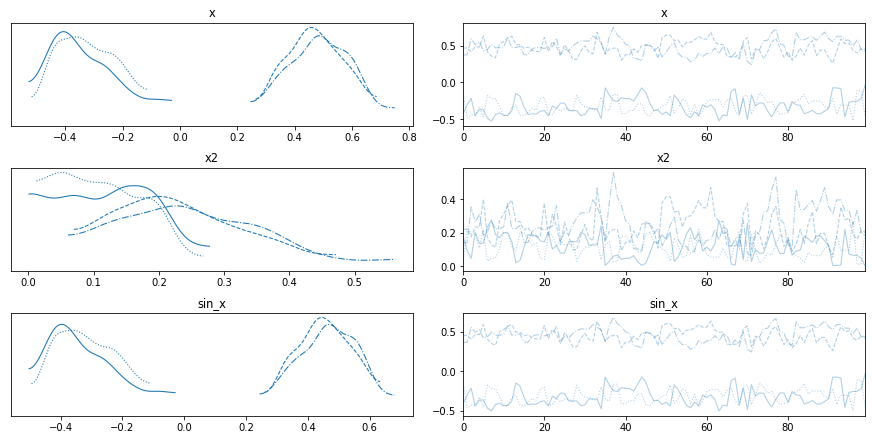

In [6]:
pm.traceplot(trace);

In [7]:
with model:
    mean_field = pm.fit(method="advi")



Average Loss = 2.2413: 100%|██████████| 10000/10000 [00:01<00:00, 7000.09it/s]
Finished [100%]: Average Loss = 2.2687


/home/konstantinos/anaconda3/envs/smc/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


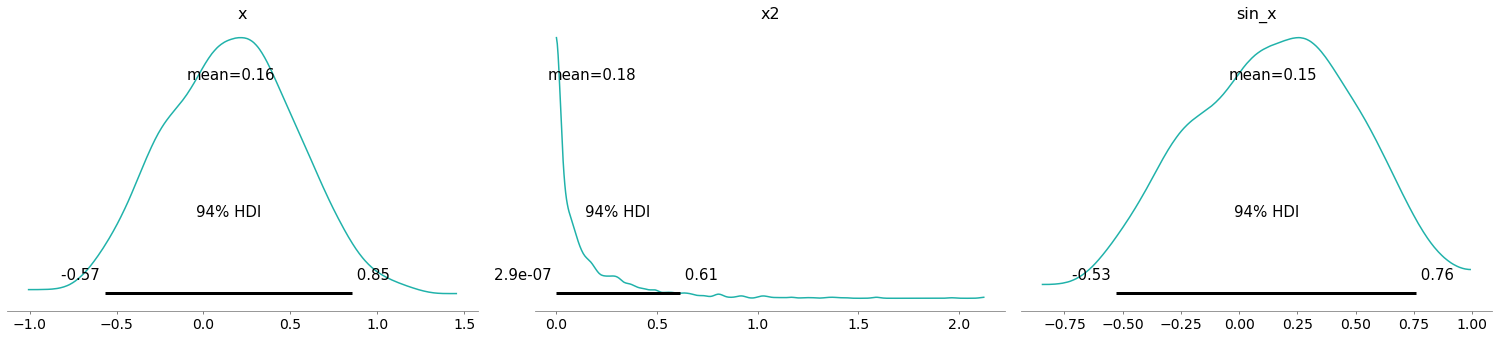

In [8]:
pm.plot_posterior(mean_field.sample(1000), color="LightSeaGreen");

In [27]:
with model:
    advi = pm.ADVI()
advi.approx.shared_params
advi.approx.mean.eval(), advi.approx.std.eval()

(array([0.34]), array([0.69314718]))

In [18]:
tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval,  # callable that returns std
)
approx = advi.fit(10000, callbacks=[tracker])

Average Loss = 2.1165: 100%|██████████| 10000/10000 [00:01<00:00, 6198.93it/s]
Finished [100%]: Average Loss = 2.1385


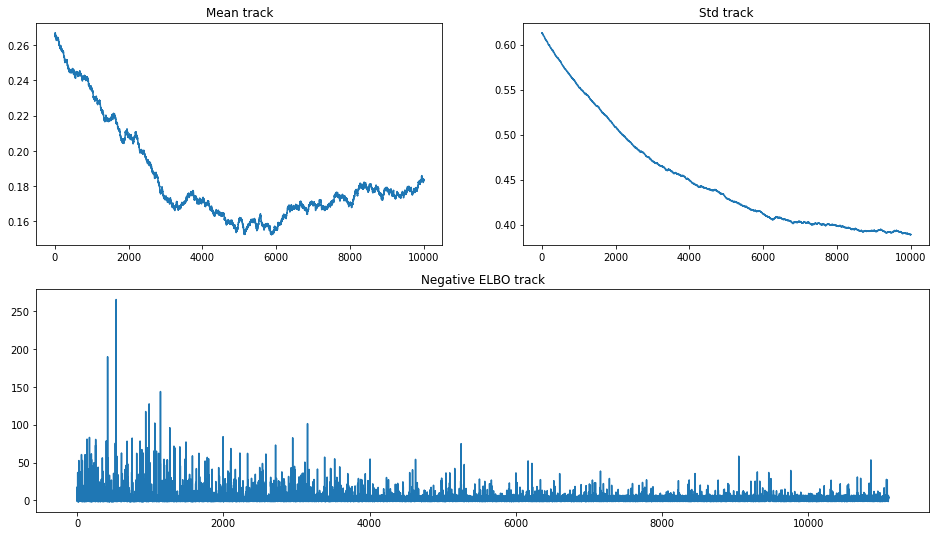

In [19]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker["mean"])
mu_ax.set_title("Mean track")
std_ax.plot(tracker["std"])
std_ax.set_title("Std track")
hist_ax.plot(advi.hist)
hist_ax.set_title("Negative ELBO track");



In [20]:
advi.refine(10000)

Average Loss = 1.9548: 100%|██████████| 10000/10000 [00:01<00:00, 6572.16it/s]
Finished [100%]: Average Loss = 1.9569


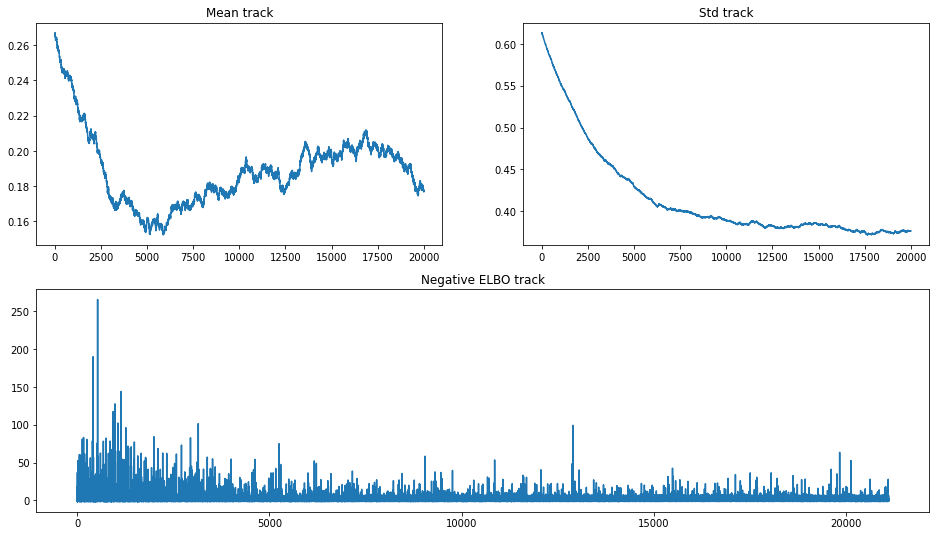

In [21]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker["mean"])
mu_ax.set_title("Mean track")
std_ax.plot(tracker["std"])
std_ax.set_title("Std track")
hist_ax.plot(advi.hist)
hist_ax.set_title("Negative ELBO track");



In [28]:


import pandas as pd
import theano.tensor as tt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X, y = load_iris(True)
X_train, X_test, y_train, y_test = train_test_split(X, y)



In [31]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [91]:
Xt = theano.shared(X_train)
yt = theano.shared(y_train)

with pm.Model() as iris_model:
    # Coefficients for features
    # Transoform to unit interval
    a = pm.Flat("a", shape=(3,))
    β = pm.Normal("β", 0, sigma=1e2, shape=(4, 3))
    p = tt.nnet.softmax(Xt.dot(β) + a)

    observed = pm.Categorical("obs", p=p, observed=yt)



/home/konstantinos/anaconda3/envs/smc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [92]:
with iris_model:
    advi = pm.fit(method="fullrank_advi")


  0%|          | 0/10000 [00:00<?, ?it/s]/home/konstantinos/anaconda3/envs/smc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/konstantinos/anaconda3/envs/smc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/konstantinos/anaconda3/envs/smc/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for 

In [94]:
df = pm.summary(advi.sample(10000))


/home/konstantinos/anaconda3/envs/smc/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


In [95]:
df.index

Index(['a[0]', 'a[1]', 'a[2]', 'β[0,0]', 'β[0,1]', 'β[0,2]', 'β[1,0]',
       'β[1,1]', 'β[1,2]', 'β[2,0]', 'β[2,1]', 'β[2,2]', 'β[3,0]', 'β[3,1]',
       'β[3,2]'],
      dtype='object')

In [96]:
mean_field.shared_params

{'mu': mu, 'rho': rho}

In [97]:
pd.DataFrame(mean_field.mean.eval(), index=df.index).to_dict()

{0: {'a[0]': 0.5399520571530084,
  'a[1]': 0.13469389649847643,
  'a[2]': -0.2898621855462532,
  'β[0,0]': 0.25665087533802644,
  'β[0,1]': 0.11952164410086656,
  'β[0,2]': -0.02160942641236726,
  'β[1,0]': 0.7748131560358379,
  'β[1,1]': -0.10017436555355115,
  'β[1,2]': -0.27996666245798485,
  'β[2,0]': -0.7182080388634613,
  'β[2,1]': 0.2856873573467567,
  'β[2,2]': 0.527914478603128,
  'β[3,0]': -1.122300081903458,
  'β[3,1]': 0.17939903114982161,
  'β[3,2]': 0.8547684993687198}}

In [98]:
advi.cov.eval()

/home/konstantinos/anaconda3/envs/smc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


array([[ 0.6072123 ,  0.12256502,  0.11762102, -0.31289662,  0.1517206 ,
         0.13143704, -0.16238469,  0.05764494,  0.07961903, -0.09417247,
         0.04069681,  0.06003837, -0.31110454,  0.13648067,  0.12773187],
       [ 0.12256502,  0.51183641,  0.13421439,  0.12048957, -0.22898142,
         0.10038008,  0.07813796, -0.12963358,  0.0741257 ,  0.04307263,
        -0.04647855,  0.01340467,  0.12812392, -0.24980673,  0.12785635],
       [ 0.11762102,  0.13421439,  0.50946083,  0.114371  ,  0.10464077,
        -0.19980335,  0.08064239,  0.07207112, -0.13211612,  0.05667309,
         0.01359416, -0.0637404 ,  0.12225105,  0.12784352, -0.21968551],
       [-0.31289662,  0.12048957,  0.114371  ,  0.72888594,  0.06057842,
         0.04077101,  0.06143728, -0.04775583, -0.04053504,  0.09773886,
        -0.05933773, -0.04117235, -0.09410392,  0.0287182 ,  0.01866494],
       [ 0.1517206 , -0.22898142,  0.10464077,  0.06057842,  0.57641543,
         0.08164758, -0.05561109,  0.08766689, 